# ECON408: Assignment 5

Instructor: Jesse Perla, UBC

## Student Name/Number: (doubleclick to edit)

### Instructions

-   Edit the above cell to include your name and student number.
-   Submit a **both** the **executed** Jupyter notebook (`.ipynb`) and a
    rendered PDF file. To save as PDF, you can use the `File` menu in
    Jupyter Lab or choose `Export` for the built-in VS Code. No need to
    use a naming convention since Canvas takes care of that for you.
-   Edit code within this notebook in the provided blanks, but feel free
    to add in extra code markup and other cells.
-   Open local to the `Project.toml` and `Manifest.toml` provided files
    in this repository or the [QuantEcon Julia
    notebooks](https://github.com/QuantEcon/lecture-julia.notebooks).

In [1]:
using LinearAlgebra, Statistics
using Distributions, Expectations, NLsolve, Parameters, Plots, LaTeXStrings
using QuantEcon, Roots, Random

## Question 1

Recall the [Lake
Model](https://julia.quantecon.org/multi_agent_models/lake_model.html)
of unemployment and employment. Summarizing, while in the labor market,
workers are employed or unemployed, where

-   $\lambda$, the job finding rate for currently unemployed workers and
    $\alpha$ is the dismissal rate for currently employed workers
-   $b$ is the entry rate into the labor force, $d$ is the exit rate,
    and $g = b - d$. New entrance into the labor force is assumed to be
    unemployed.
-   $E_t$ is the total number of employed workers, $U_t$ is the total
    number of unemployed workers and $N_t = E_t + U_t$ is the total
    number of workers in the labor force.
-   The employment and unemployment rate are $e_t \equiv E_t / N_t$ and
    $u_t \equiv U_t / N_t$ respectively.
-   Define $X_t \equiv \left(\begin{matrix}U_t\\E_t\end{matrix}\right)$
    and $x_t \equiv \left(\begin{matrix}u_t\\e_t\end{matrix}\right)$.

With this, we constructed the equation for the evolution of the state
vector $X_{t+1}$ as

$$
X_{t+1} = A X_t
\quad \text{where} \quad
A \equiv
\begin{pmatrix}
    (1-d)(1-\lambda) + b & (1-d)\alpha + b  \\
    (1-d)\lambda & (1-d)(1-\alpha)
\end{pmatrix}
$$

And

$$
x_{t+1} = \hat{A} x_t
\quad \text{where} \quad
\hat{A} \equiv \frac{1}{1+g}A
$$

Finally, the Markov chain for an agent (before exit) is $$
P = \left(
        \begin{matrix}
            1 - \lambda & \lambda \\
            \alpha & 1 - \alpha
        \end{matrix}
    \right)
$$

In the lectures we had code for general simulations using a model,
rewritten below:

In [2]:
# Reusable functions, do not modify without clearly annotating your changes.
function simulate_linear(A, x_0, T)
    X = zeros(length(x_0), T+1)
    X[:,1] = x_0    
    for t in 2:T+1
        X[:, t] = A * X[:, t-1]
    end
    return X
end

function linear_steady_state(A, x_0 = ones(size(A,1)) / size(A,1))
    sol = fixedpoint(x -> A * x, x_0)
    converged(sol) || error("Failed to converge in $(result.iterations) iterations")
    return sol.zero
end

linear_steady_state (generic function with 2 methods)

Using the above code, we can create a model type which encapsulates the
Markov chain and the linear dynamics.

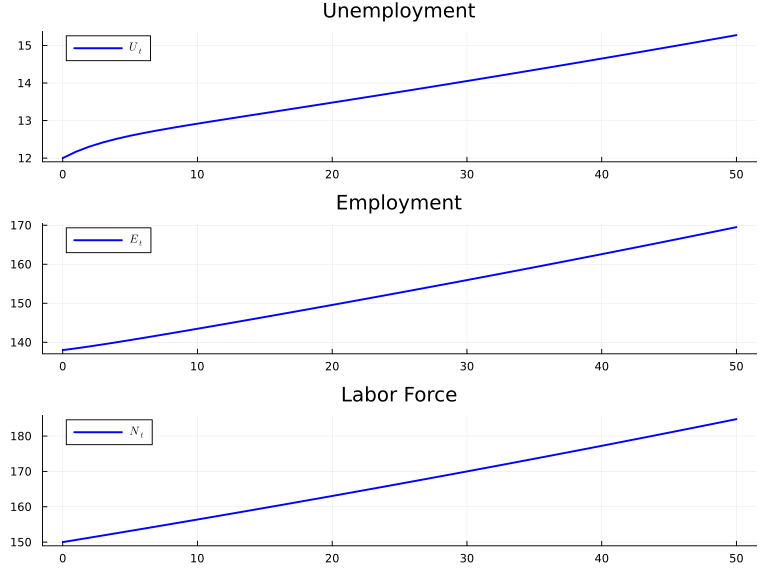

In [3]:
function LakeModel(;lambda = 0.283, alpha = 0.013, b = 0.0124, d = 0.00822)
    g = b - d
    A = [(1 - lambda) * (1 - d) + b      (1 - d) * alpha + b
        (1 - d) * lambda                 (1 - d) * (1 - alpha)]
    A_hat = A ./ (1 + g)
    P = [(1 - lambda)     lambda
          alpha          (1 - alpha)]
    return (;A, A_hat, P, lambda, alpha, b, d, g)
end
lm = LakeModel()
N_0 = 150      # population
e_0 = 0.92     # initial employment rate
u_0 = 1 - e_0  # initial unemployment rate
T = 50         # simulation length

U_0 = u_0 * N_0
E_0 = e_0 * N_0
X_0 = [U_0; E_0]

X_path = simulate_linear(lm.A, X_0, T)

U_t = X_path[1, :]
E_t = X_path[2, :]
N_t = sum(X_path, dims = 1)' # Adds up over columns then make a 

plt_unemp = plot(0:T, U_t, color = :blue, lw = 2, grid = true, title = "Unemployment", label=L"$U_t$")
plt_emp = plot(0:T, E_t, color = :blue, lw = 2, grid = true, title="Employment", label=L"$E_t$")
plt_labor = plot(0:T, N_t, color = :blue, lw = 2, grid = true, title="Labor Force", label=L"$N_t$")

plot(plt_unemp, plt_emp, plt_labor, layout = (3, 1), size = (800, 600))

Similarly, we can plot the evolution of the employment and unemployment
rates after finding the steady state:

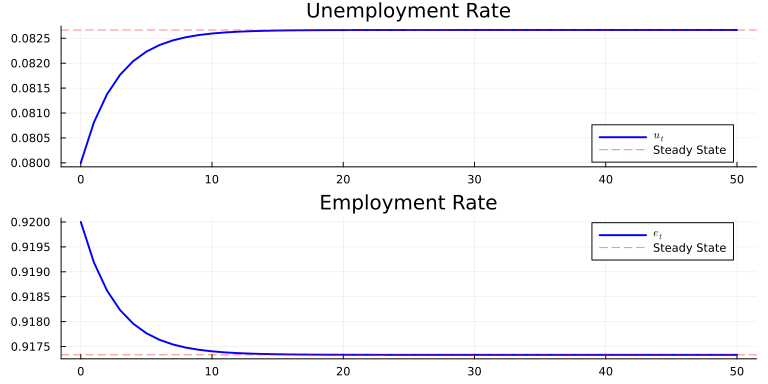

In [4]:
x_0 = [u_0; e_0]
x_ss = linear_steady_state(lm.A_hat)
x_path = simulate_linear(lm.A_hat, x_0, T)
u_t = x_path[1, :]
e_t = x_path[2, :]
plt_unemp_rate = plot(0:T, u_t, color = :blue, lw = 2, grid = true, title = "Unemployment Rate", label=L"$u_t$")
hline!(plt_unemp_rate, [x_ss[1]], color = :red, alpha = 0.5, linestyle = :dash, label = "Steady State")
plt_emp_rate = plot(0:T, e_t, color = :blue, lw = 2, grid = true, title="Employment Rate", label=L"$e_t$")
hline!(plt_emp_rate, [x_ss[2]], color = :red, alpha = 0.5, linestyle = :dash, label = "Steady State")
plot(plt_unemp_rate, plt_emp_rate, layout = (2, 1), size = (800, 400))

### Part (a)

Repeating the above code, plot the dynamics of the unemployment and
employment rates for the model with `b = d = 0`, but keeping all of the
other parameters as given.

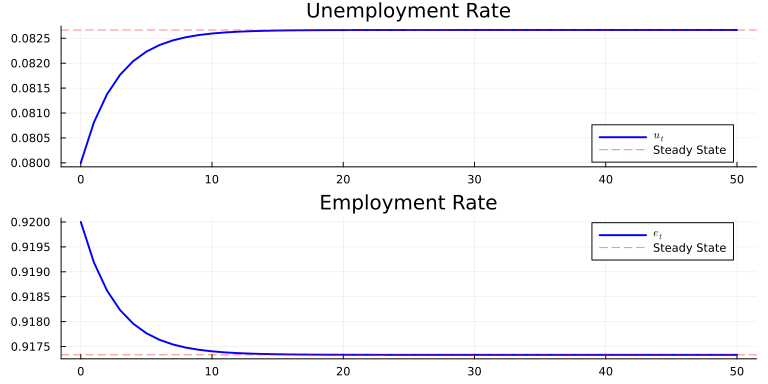

In [5]:
# edit your code here
lm = LakeModel()
N_0 = 150      # population
e_0 = 0.92     # initial employment rate
u_0 = 1 - e_0  # initial unemployment rate
T = 50         # simulation length

U_0 = u_0 * N_0
E_0 = e_0 * N_0
x_0 = [u_0; e_0]
x_ss = linear_steady_state(lm.A_hat)
x_path = simulate_linear(lm.A_hat, x_0, T)
u_t = x_path[1, :]
e_t = x_path[2, :]
plt_unemp_rate = plot(0:T, u_t, color = :blue, lw = 2, grid = true, title = "Unemployment Rate", label=L"$u_t$")
hline!(plt_unemp_rate, [x_ss[1]], color = :red, alpha = 0.5, linestyle = :dash, label = "Steady State")
plt_emp_rate = plot(0:T, e_t, color = :blue, lw = 2, grid = true, title="Employment Rate", label=L"$e_t$")
hline!(plt_emp_rate, [x_ss[2]], color = :red, alpha = 0.5, linestyle = :dash, label = "Steady State")
plot(plt_unemp_rate, plt_emp_rate, layout = (2, 1), size = (800, 400))

Interpret why this is different from the previous case (talk about
transition dynamics as well as the steady-states)

(double click to edit your answer)

### Part (b)

The Markov chain for an individual starting in the employment state can
be simulated using the markov chain already calculated in our previous
code,

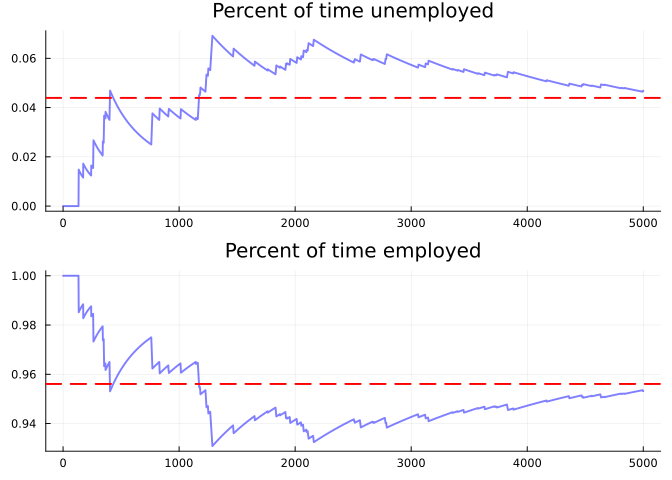

In [6]:
lm = LakeModel(;lambda = 0.283, alpha = 0.013, b = 0.0, d = 0.0)
mc = MarkovChain(lm.P, [0; 1])     # 0=unemployed, 1=employed
xbar = stationary_distributions(mc)[1]

T = 5000

s_path = simulate(mc, T; init=2) # starts in state 2
s̄_e = cumsum(s_path) ./ (1:T)
s̄_u = 1 .- s̄_e
s_bars = [s̄_u s̄_e]

plt_unemp = plot(title = "Percent of time unemployed", 1:T, s_bars[:,1],color = :blue, lw = 2,
                 alpha = 0.5, label = "", grid = true)
plot!(plt_unemp, [xbar[1]], linetype = :hline, linestyle = :dash, color=:red, lw = 2, label = "")
plt_emp = plot(title = "Percent of time employed", 1:T, s_bars[:,2],color = :blue, lw = 2,
               alpha = 0.5, label = "", grid = true)
plot!(plt_emp, [xbar[2]], linetype = :hline, linestyle = :dash, color=:red, lw = 2, label = "")
plot(plt_unemp, plt_emp, layout = (2, 1), size=(700,500))

Modify this same graph, but now start the agent in employed state,

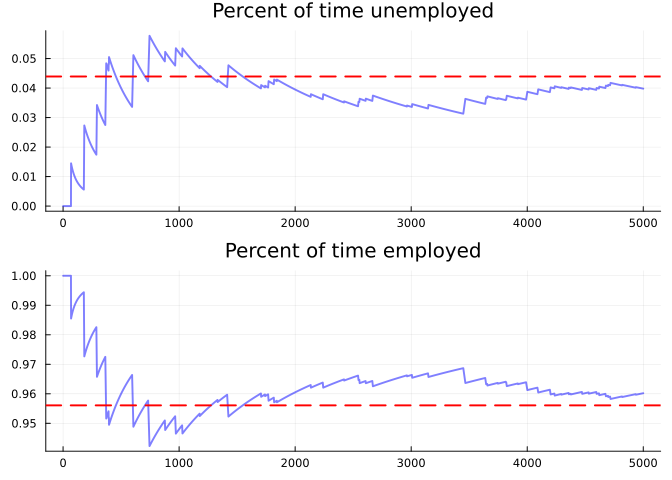

In [7]:
# edit your code here
lm = LakeModel(;lambda = 0.283, alpha = 0.013, b = 0.0, d = 0.0)
mc = MarkovChain(lm.P, [0; 1])     # 0=unemployed, 1=employed
xbar = stationary_distributions(mc)[1]

T = 5000

s_path = simulate(mc, T; init=2) # starts in state 2
s̄_e = cumsum(s_path) ./ (1:T)
s̄_u = 1 .- s̄_e
s_bars = [s̄_u s̄_e]

plt_unemp = plot(title = "Percent of time unemployed", 1:T, s_bars[:,1],color = :blue, lw = 2,
                 alpha = 0.5, label = "", grid = true)
plot!(plt_unemp, [xbar[1]], linetype = :hline, linestyle = :dash, color=:red, lw = 2, label = "")
plt_emp = plot(title = "Percent of time employed", 1:T, s_bars[:,2],color = :blue, lw = 2,
               alpha = 0.5, label = "", grid = true)
plot!(plt_emp, [xbar[2]], linetype = :hline, linestyle = :dash, color=:red, lw = 2, label = "")
plot(plt_unemp, plt_emp, layout = (2, 1), size=(700,500))

Interpret these graphs. In particular: (1) why are the different; (2)
why does it converge; and (3) why does it converge to the same point?.

(double click to edit your answer)

## Question 2

Take the same lake model above, but consider a variation where workers
will spend a portion of their lives as a student.

The following describes the probabilities

-   $\lambda$, the job finding rate for currently unemployed workers
    transitioning directly to employment
-   $\gamma$ is the probability of an unemployed working going to study
    or learn new skills (hence $1 - \lambda - \gamma$ is the probability
    of an unemployed worker remains unemployed)
-   $\alpha$ is the dismissal rate for currently employed workers where
    they enter unemployment. Employed workers do not directly enter the
    studying state
-   $\delta$ is the probability of a student transitioning to employment
    from work placement. They never go directly to unemployment
-   There is no entry or exit from the labor force
    (i.e. $g = b = d = 0$)
-   We normalize the population to be $N_t = 1$, and define the
    employment and unemployment rate as $e_t, u_t$. The proportion of
    students is $s_t$. Note $e_t + u_t + s_t = 1$.
-   Define
    $x_t \equiv \left(\begin{matrix}u_t\\ e_t\\ s_t \end{matrix}\right)$.

### Part (a)

Using a similar method to the previous question, define a function which
creates a model with this process, and carefully define the Markov Chain
transition matrices. Hint: Is there a difference now between the Markov
Chain and the functions for the linear dynamics?

In [8]:
# edit your code here, modifying the old method.  You will not need to have a separate A and A_hat matrix.  Consider if even the P is enough?

# Note the default values for gamma and delta,

function NewLakeModel(;lambda = 0.283, alpha = 0.013, b = 0, d = 0, gamma = 0.05, delta = 0.2)
    g = b - d
    A = [(1 - lambda) * (1 - d) + b      (1 - d) * alpha + b
        (1 - d) * lambda                 (1 - d) * (1 - alpha)]
    A_hat = A ./ (1 + g)
    P = [(1 - lambda)     lambda
          alpha          (1 - alpha)]
    return (;A, A_hat, P, lambda, alpha, b, d, g)
end

NewLakeModel (generic function with 1 method)

Plot the evolution equation unemployment, employment, and studying rates
using your new function.

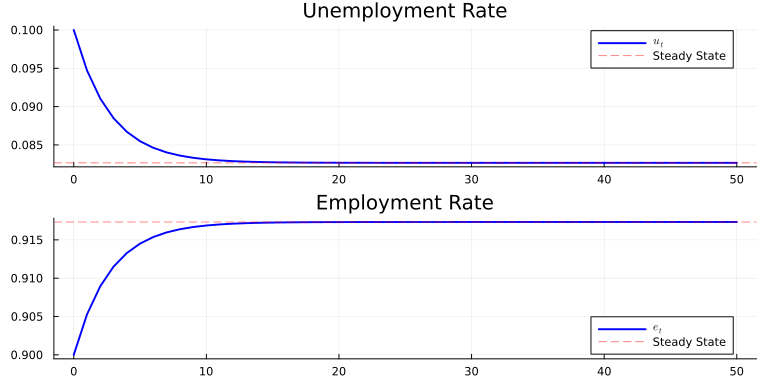

In [9]:
# edit your code here
lm = LakeModel() # call new function
N_0 = 150      # population
e_0 = 0.90     # initial employment rate
s_0 = 0.04     # initial student rate
u_0 = 1 - e_0  # - s_0 when ready
T = 50         # simulation length
x_0 = [u_0; e_0]  # Add your s_0 after your code is functional.
x_ss = linear_steady_state(lm.A_hat)
x_path = simulate_linear(lm.A_hat, x_0, T)
u_t = x_path[1, :]
e_t = x_path[2, :]
plt_unemp_rate = plot(0:T, u_t, color = :blue, lw = 2, grid = true, title = "Unemployment Rate", label=L"$u_t$")
hline!(plt_unemp_rate, [x_ss[1]], color = :red, alpha = 0.5, linestyle = :dash, label = "Steady State")
plt_emp_rate = plot(0:T, e_t, color = :blue, lw = 2, grid = true, title="Employment Rate", label=L"$e_t$")
hline!(plt_emp_rate, [x_ss[2]], color = :red, alpha = 0.5, linestyle = :dash, label = "Steady State")
plot(plt_unemp_rate, plt_emp_rate, layout = (2, 1), size = (800, 400))

### Part (b)

Here we will investigate how studying impacts the longrun steady-state

First, what is the longrun employment and unemployment rate when
`gamma = delta = 0`?

In [10]:
# edit your code here

Next look at the case where `gamma = 0.3` and `delta = 0.1`. What is the
longrun employment and unemployment rate?

In [11]:
# edit your code here

Next look at the case where `gamma = 0.3` and `delta = 1.0`. What is the
longrun employment and unemployment rate?

In [12]:
# edit your code here

Finally, interpret the reasons for differences in the longrun
unemployment rate for these three cases.

## Question 3

Take the [McCall search model with
separation](https://julia.quantecon.org/dynamic_programming/mccall_model_with_separation.html)
we discussed in class.

That implemented the following Bellman equation: $$
V(w) = u(w) + \beta [(1-\alpha)V(w) + \alpha U ]
$$

and

$$
U = u(c) +
  \beta (1 - \gamma) U +
  \beta \gamma \sum_i \max \left\{ U, V(w_i) \right\} p_i
$$

where $\gamma$ is the probability of a job offer while unemployed,
$\alpha$ is the probability of exogenous separation, u$u$ is the utility
function, and $w_i$ is the wage offer with probability $p_i$.

The code which solves for this Bellman Equation is

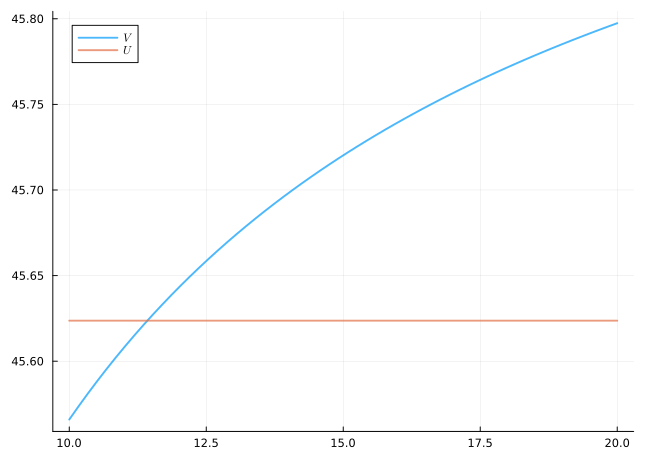

In [13]:
function solve_mccall_model(mcm; U_iv = 1.0, V_iv = ones(length(mcm.w)), tol = 1e-5,
                            iter = 2_000)
    (; α, β, σ, c, γ, w, dist, u) = mcm

    # parameter validation
    @assert c > 0.0
    @assert minimum(w) > 0.0 # perhaps not strictly necessary, but useful here

    # necessary objects
    u_w = u.(w, σ)
    u_c = u(c, σ)
    E = expectation(dist) # expectation operator for wage distribution

    # Bellman operator T. Fixed point is x* s.t. T(x*) = x*
    function T(x)
        V = x[1:end-1]
        U = x[end]
        [u_w + β * ((1 - α) * V .+ α * U);
         u_c + β * (1 - γ) * U + β * γ * E * max.(U, V)]
    end

    # value function iteration
    x_iv = [V_iv; U_iv] # initial x val
    xstar = fixedpoint(T, x_iv, iterations = iter, xtol = tol, m = 0).zero
    V = xstar[1:end-1]
    U = xstar[end]

    # compute the reservation wage
    wbarindex = searchsortedfirst(V .- U, 0.0)
    if wbarindex >= length(w) # if this is true, you never want to accept
        w̄ = Inf
    else
        w̄ = w[wbarindex] # otherwise, return the number
    end

    # return a NamedTuple, so we can select values by name
    return (V = V, U = U, w̄ = w̄)
end
# a default utility function
u(c, σ) = (c^(1 - σ) - 1) / (1 - σ)

# model constructor
McCallModel = @with_kw (α = 0.2,
    β = 0.98, # discount rate
    γ = 0.7,
    c = 6.0, # unemployment compensation
    σ = 2.0,
    u = u, # utility function
    w = range(10, 20, length = 60), # wage values
    dist = BetaBinomial(59, 600, 400)) # distribution over wage values
# plots setting


mcm = McCallModel()
(; V, U) = solve_mccall_model(mcm)
U_vec = fill(U, length(mcm.w))

plot(mcm.w, [V U_vec], lw = 2, α = 0.7, label = [L"V" L"U"])    

Take the above equation, and consider a variation where there is
on-the-job searching for better jobs. With probability $\delta$ the
worker gets a job offer while employed

$$
V(w) = u(w) + \beta [(1-\alpha-\delta)V(w) + \alpha U + \delta \sum_i \max \left\{ V(w), V(w_i) \right\} p_i ]
$$

Note that the $\max$ is taken over the current wage and the arrival with
the same

$$
U = u(c) +
  \beta (1 - \gamma) U +
  \beta \gamma \sum_i \max \left\{ U, V(w_i) \right\} p_i
$$

Modify the code above to implement this new Bellman equation. Hint:
after adding the new constant, you will probably only need to change the
`u_w + β * ((1 - α) * V .+ α * U)` function to include the new term.

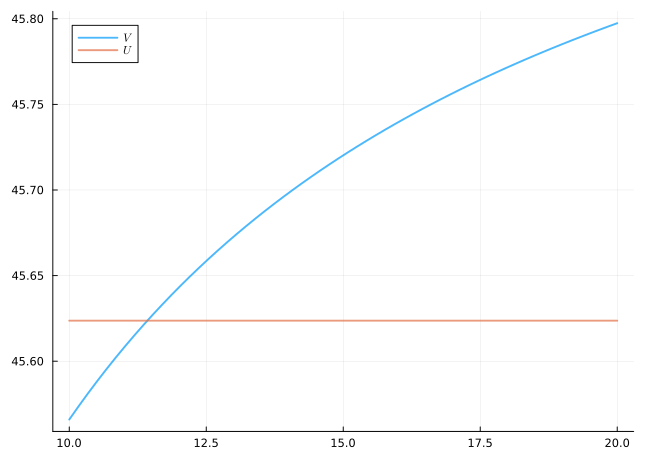

In [14]:
# edit your code here.  Hint: add parameter and look at the T operator

function solve_mccall_model(mcm; U_iv = 1.0, V_iv = ones(length(mcm.w)), tol = 1e-5,
                            iter = 2_000)
    (; α, β, σ, c, γ, w, dist, u) = mcm

    # parameter validation
    @assert c > 0.0
    @assert minimum(w) > 0.0 # perhaps not strictly necessary, but useful here

    # necessary objects
    u_w = u.(w, σ)
    u_c = u(c, σ)
    E = expectation(dist) # expectation operator for wage distribution

    # Bellman operator T. Fixed point is x* s.t. T(x*) = x*
    function T(x)
        V = x[1:end-1]
        U = x[end]
        [u_w + β * ((1 - α) * V .+ α * U);
         u_c + β * (1 - γ) * U + β * γ * E * max.(U, V)]
    end

    # value function iteration
    x_iv = [V_iv; U_iv] # initial x val
    xstar = fixedpoint(T, x_iv, iterations = iter, xtol = tol, m = 0).zero
    V = xstar[1:end-1]
    U = xstar[end]

    # compute the reservation wage
    wbarindex = searchsortedfirst(V .- U, 0.0)
    if wbarindex >= length(w) # if this is true, you never want to accept
        w̄ = Inf
    else
        w̄ = w[wbarindex] # otherwise, return the number
    end

    # return a NamedTuple, so we can select values by name
    return (V = V, U = U, w̄ = w̄)
end
# a default utility function
u(c, σ) = (c^(1 - σ) - 1) / (1 - σ)

# model constructor
McCallModel = @with_kw (α = 0.2,
    β = 0.98, # discount rate
    γ = 0.7,
    c = 6.0, # unemployment compensation
    σ = 2.0,
    u = u, # utility function
    w = range(10, 20, length = 60), # wage values
    dist = BetaBinomial(59, 600, 400)) # distribution over wage values
# plots setting


mcm = McCallModel()
(; V, U) = solve_mccall_model(mcm)
U_vec = fill(U, length(mcm.w))

plot(mcm.w, [V U_vec], lw = 2, α = 0.7, label = [L"V" L"U"])    